# Financial Distress Prediction Project
### Context
The project aims to identify companies that are likely to deal with bankruptcy.
Each company has a score/target **Financial Distress** associated with the probability of leading to bankruptcy.
### Content of Dataset
**First column: Company** represents sample companies.

**Second column: Time** shows different time periods that data belongs to. Time series length varies between 1 to 14 for each company.

**Third column**: The target variable is denoted by "**Financial Distress**" if it is greater than -0.50 the company should be considered as **healthy (0)**. Otherwise, it would be regarded as **financially distressed (1)**.

**Fourth column to the last column**: The anonymized features denoted by **x1** to **x83**, are some financial and non-financial characteristics of the sampled companies. These features belong to the previous time period, which should be used to predict whether the company will be financially distressed or not (classification). Feature **x80** is a **categorical variable**.

### Goals of the project

As a classification problem, finding:

- the most indicative features of financial distress
- a well performing machine learning model to predict the state of bankruptcy's risk.
## Imports

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Data preparation
Data from https://www.kaggle.com/datasets/shebrahimi/financial-distress
### Reading the data

In [2]:
df = pd.read_csv("Financial-Distress.csv")

### Making column names and values look uniform

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
df.head()

,company,time,financial_distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


### Records count

In [5]:
df.shape

(3672, 86)

### Feature **x80**

In [6]:
df.dtypes[df.dtypes == 'object'].index

Index([], dtype='object')

It seem's there no categorical feature as **x80** should be.

In [7]:
df["x80"] = df["x80"].astype(dtype="str")

### Features **company** and **time** useless

In [8]:
df = df.drop(columns={"company", "time"})

### Target **financial_distress** preparation for classification
According to the limit of **-0.50**, the target becomes binary.

In [9]:
df["financial_distress"] = (df["financial_distress"] <= np.float64(-0.5)).astype(int)
df["financial_distress"]

0       0
1       0
2       0
3       1
4       0
       ..
3667    0
3668    0
3669    0
3670    0
3671    0
Name: financial_distress, Length: 3672, dtype: int64

## EDA – Exploratory Data Analysis
### Describing numerical variables

In [10]:
pd.set_option('display.max_rows', 100)
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
financial_distress,3672.0,0.04,0.19,0.00,0.00,0.00,0.00,1.000000e+00
x1,3672.0,1.39,1.45,0.08,0.95,1.18,1.51,5.195000e+01
x2,3672.0,0.13,0.12,-0.26,0.05,0.11,0.19,7.500000e-01
x3,3672.0,0.62,0.18,0.02,0.50,0.64,0.75,9.700000e-01
x4,3672.0,0.87,0.57,0.00,0.55,0.78,1.04,6.840000e+00
x5,3672.0,0.15,0.12,-0.27,0.07,0.13,0.22,8.600000e-01
x6,3672.0,0.11,0.21,-0.63,-0.03,0.10,0.23,9.300000e-01
x7,3672.0,0.78,1.03,0.04,0.44,0.64,0.90,3.884000e+01
x8,3672.0,39.27,4305.69,-145000.00,0.06,0.14,0.27,2.090000e+05
x9,3672.0,0.33,0.35,-3.61,0.16,0.30,0.48,3.810000e+00


### Checking missing values

In [11]:
df.isna().sum().sum()

np.int64(0)

There's **no** *NaN* values.

### Looking at the target variable **financial_distress**

In [12]:
df.financial_distress.value_counts(normalize=True)

financial_distress
0    0.962963
1    0.037037
Name: proportion, dtype: float64

In [13]:
global_bankruptcy_rate = df.financial_distress.mean()
round(global_bankruptcy_rate, 4)

np.float64(0.037)

The target is strongly imbalanced. Then later I'll choose ROC_AUC for score's evaluations.
### Looking at numerical and categorical variables

In [14]:
numerical_vars = df.drop(columns=["financial_distress"]).select_dtypes(include=['int64', 'float64'])
categorical_vars = df.select_dtypes(include=['object'])
print("There're", len(numerical_vars.columns),  "numerical variables :")
print(numerical_vars.columns)
print("\nThere're", len(categorical_vars.columns),  "categorical variables :")
print(categorical_vars.columns)

There're 82 numerical variables :
Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',
       'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31',
       'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41',
       'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51',
       'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61',
       'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71',
       'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x81', 'x82',
       'x83'],
      dtype='object')

There're 1 categorical variables :
Index(['x80'], dtype='object')


In [15]:
numerical = numerical_vars.columns.to_list()
categorical = categorical_vars.columns.to_list()
categorical

['x80']

In [16]:
df[categorical].nunique()

x80    37
dtype: int64

### Correlation matrix

In [17]:
corr = df[numerical].corr()
corr

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x73,x74,x75,x76,x77,x78,x79,x81,x82,x83
x1,1.000000,0.208851,-0.440321,-0.035504,0.109543,0.535425,0.914489,0.007329,-0.000506,0.296670,...,-0.040829,0.007974,0.135594,0.138233,0.119818,0.066994,-0.045919,0.053595,-0.067678,-0.087026
x2,0.208851,1.000000,-0.504509,0.114046,0.892480,0.298078,0.214098,0.014020,0.729858,0.735503,...,0.052388,0.014677,0.010825,0.019887,0.034792,-0.009057,-0.104102,0.281884,-0.144404,-0.095881
x3,-0.440321,-0.504509,1.000000,0.094481,-0.356252,-0.593620,-0.398730,-0.006290,-0.030976,-0.661908,...,0.184080,0.014103,-0.227217,-0.227341,-0.174159,-0.041958,0.102163,-0.111055,0.067579,0.107194
x4,-0.035504,0.114046,0.094481,1.000000,0.194218,0.068274,-0.054573,-0.013797,0.135739,0.064635,...,-0.003886,0.025610,0.084316,0.088898,0.091231,0.057900,-0.044051,0.203058,-0.041700,0.022684
x5,0.109543,0.892480,-0.356252,0.194218,1.000000,0.236113,0.110410,-0.011965,0.687468,0.645829,...,0.035566,-0.000850,-0.003010,0.005078,0.018191,-0.039424,-0.120217,0.266739,-0.144725,-0.067050
x6,0.535425,0.298078,-0.593620,0.068274,0.236113,1.000000,0.455435,-0.004117,0.005126,0.441091,...,-0.075941,0.013935,0.161748,0.164698,0.134685,0.052731,-0.084758,0.101647,-0.076454,-0.066007
x7,0.914489,0.214098,-0.398730,-0.054573,0.110410,0.455435,1.000000,0.013492,0.019448,0.290069,...,-0.057026,0.006631,0.136802,0.137437,0.114663,0.072096,-0.017951,0.064812,-0.080588,-0.100397
x8,0.007329,0.014020,-0.006290,-0.013797,-0.011965,-0.004117,0.013492,1.000000,0.028458,0.007163,...,-0.000466,0.010526,0.013211,0.013657,0.021835,0.039196,0.036357,-0.000214,0.011114,0.001973
x9,-0.000506,0.729858,-0.030976,0.135739,0.687468,0.005126,0.019448,0.028458,1.000000,0.314260,...,0.210475,0.030241,-0.144849,-0.135572,-0.077605,0.001246,0.005528,0.181116,-0.126204,-0.078322
x10,0.296670,0.735503,-0.661908,0.064635,0.645829,0.441091,0.290069,0.007163,0.314260,1.000000,...,-0.255167,-0.023920,0.285670,0.287692,0.219425,0.006016,-0.194802,0.395664,-0.021740,-0.001147


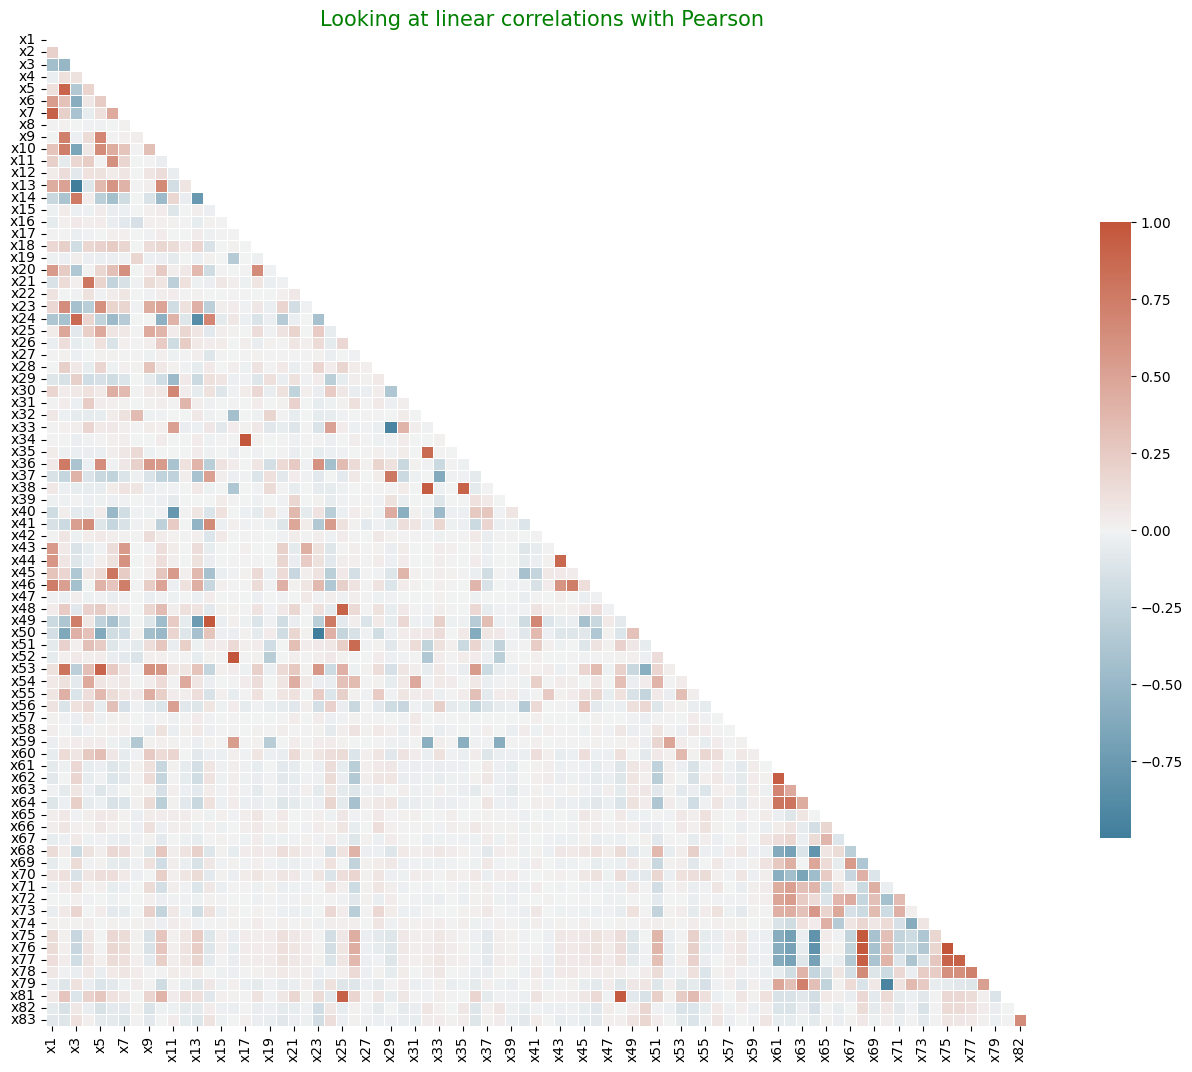

In [18]:
mask = np.triu(np.ones_like(corr, dtype = bool))
f, ax = plt.subplots(figsize = (16, 16))

cmap = sns.diverging_palette(230, 20, as_cmap = True)
plt.grid(visible = False)
plt.title('Looking at linear correlations with Pearson', color='green', fontsize=15)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot = False, linewidths=.5, cbar_kws={"shrink": .5});

## Setting up the validation framework
### Perform the train/validation/test split with Scikit-Learn

In [19]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=39)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=39)
len(df_train), len(df_val), len(df_test)

(2202, 735, 735)

In [20]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [21]:
y_full_train = df_full_train.financial_distress.values
y_train = df_train.financial_distress.values
y_val = df_val.financial_distress.values
y_test = df_test.financial_distress.values

In [22]:
del df_full_train['financial_distress']
del df_train['financial_distress']
del df_val['financial_distress']
del df_test['financial_distress'] 

## Feature importance
### Risk ratio

In [23]:
df_group = df.groupby("x80").financial_distress.agg(['mean', 'count'])
df_group['diff'] = df_group['mean'] - global_bankruptcy_rate
df_group['risk'] = df_group['mean'] / global_bankruptcy_rate
display(df_group.sort_values("risk", ascending = False))

,mean,count,diff,risk
x80,,,,
13,0.250000,4,0.212963,6.750000
12,0.177215,79,0.140178,4.784810
11,0.093750,32,0.056713,2.531250
27,0.085106,47,0.048069,2.297872
7,0.083333,12,0.046296,2.250000
1,0.071429,14,0.034392,1.928571
22,0.070064,157,0.033027,1.891720
20,0.067308,104,0.030271,1.817308
21,0.067227,119,0.030190,1.815126


### Mutual information

In [24]:
mutual_info_score(df.x80, df.financial_distress)

np.float64(0.01289788037037554)

### Correlation with target

In [25]:
df[numerical].corrwith(df.financial_distress).abs().sort_values(ascending = False)

x14    0.291381
x49    0.277275
x9     0.269254
x2     0.242083
x10    0.234725
x5     0.229287
x3     0.207098
x13    0.207098
x55    0.192320
x53    0.190683
x37    0.184847
x23    0.181492
x50    0.181490
x36    0.180824
x24    0.171165
x60    0.162371
x25    0.110164
x45    0.106667
x41    0.105527
x6     0.103371
x42    0.102555
x46    0.089144
x51    0.083612
x81    0.079222
x21    0.078001
x48    0.076500
x8     0.068213
x28    0.064459
x18    0.061836
x29    0.060343
x26    0.057932
x19    0.056897
x56    0.056207
x4     0.054880
x20    0.053059
x1     0.049967
x7     0.048710
x58    0.047176
x11    0.046870
x64    0.045377
x47    0.041389
x66    0.037171
x59    0.034495
x40    0.033438
x54    0.033033
x63    0.031242
x83    0.027856
x68    0.027842
x82    0.027329
x76    0.027029
x75    0.024950
x72    0.024736
x16    0.024101
x73    0.023559
x61    0.023377
x52    0.022613
x70    0.020714
x65    0.020240
x74    0.020164
x69    0.017939
x12    0.016779
x62    0.016557
x79    0

## One-hot encoding

In [26]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)

In [27]:
X_train = dv.fit_transform(train_dict)
X_train.shape

(2202, 118)

In [28]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Training logistic regression with Scikit-Learn

In [29]:
model = LogisticRegression(solver="liblinear", max_iter=500, random_state=39)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=39, solver='liblinear')

In [30]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([2.18498065e-09, 1.06932211e-01, 6.23620622e-02, 1.87783451e-02,
       6.53658557e-02, 3.54531083e-02, 1.09652367e-02, 8.01686238e-03,
       2.67662900e-04, 8.85217541e-03, 1.43479964e-01, 4.89573198e-03,
       1.15133378e-02, 1.95367492e-02, 8.11912207e-03, 9.19646231e-04,
       4.72937391e-01, 3.50553930e-02, 2.52186513e-01, 5.42199375e-02,
       1.80115064e-18, 5.85997212e-02, 1.23401772e-02, 1.29605570e-01,
       4.82826013e-06, 2.67278726e-04, 2.03853015e-02, 2.00831004e-46,
       7.05500151e-03, 1.08703890e-01, 1.56902920e-04, 5.37946917e-02,
       1.66689641e-02, 2.93367769e-02, 3.79453104e-02, 1.36042942e-01,
       9.22312417e-02, 2.55473075e-03, 5.73683821e-02, 1.14203682e-03,
       7.06445899e-04, 6.66583330e-04, 5.12378353e-11, 3.01639683e-02,
       9.60998859e-02, 1.77418680e-02, 1.42330170e-01, 1.17026725e-02,
       2.66822678e-03, 1.46558607e-04, 3.18615588e-04, 2.49329958e-06,
       3.23281394e-02, 2.93823639e-02, 4.47209470e-08, 2.37133086e-02,
      

In [31]:
roc_auc_score(y_val, y_pred)

np.float64(0.8642725398719757)

### Tuning the C-value 

In [36]:
scores = {}
for C in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=500, random_state=39)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)
    scores[C] = round(auc_score, 3)
    print(f"C = {C}:\t roc_auc_score = {auc_score}")

C = 0.01:	 roc_auc_score = 0.8604752088532059
C = 0.1:	 roc_auc_score = 0.8662797005533254
C = 1:	 roc_auc_score = 0.8642725398719757
C = 10:	 roc_auc_score = 0.8584138005858739
C = 100:	 roc_auc_score = 0.8617229033308018


In [37]:
scores

{0.01: np.float64(0.86),
 0.1: np.float64(0.866),
 1: np.float64(0.864),
 10: np.float64(0.858),
 100: np.float64(0.862)}

In [38]:
print(f"The best `C` is {max(scores, key = scores.get)}.")

The best `C` is 0.1.


## Decision trees

In [40]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.6704459151567755)

### Tuning *max_depth*

In [41]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.731
   2 -> 0.798
   3 -> 0.798
   4 -> 0.736
   5 -> 0.649
   6 -> 0.640
  10 -> 0.627
  15 -> 0.691
  20 -> 0.635
None -> 0.695


### Tuning *min_samples_leaf*

In [42]:
scores = []

for depth in [2, 3, 4]:
    for s in [1, 5, 10, 15, 20, 50, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [43]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [44]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             2      3      4
min_samples_leaf                     
1                 0.798  0.798  0.736
5                 0.798  0.877  0.866
10                0.798  0.877  0.847
15                0.798  0.909  0.902
20                0.798  0.908  0.891
50                0.800  0.910  0.897
100               0.839  0.910  0.904
200               0.900  0.927  0.926
500               0.857  0.857  0.857

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

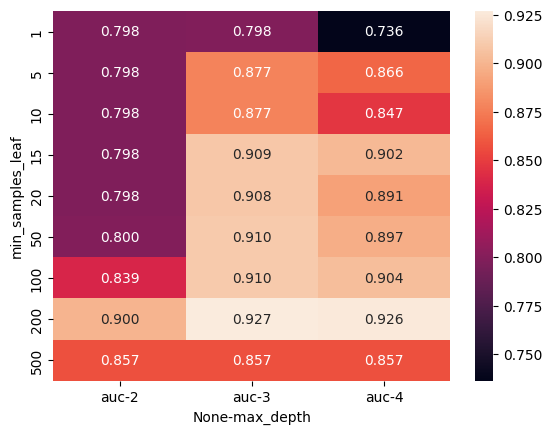

In [45]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

The best combination needs **max_depth = 3** and **min_samples_leaf = 200** for **AUC = 0.927**

## Random Forest

In [47]:
rf = RandomForestClassifier(n_estimators=10,
                           random_state=39,
                           n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print("AUC :", round(roc_auc_score(y_val, y_pred), 2))

AUC : 0.63


### Tuning **n_estimators**

In [53]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n,
                           random_state=39,
                           n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [54]:
df_scores = pd.DataFrame(scores, columns=["n_estimators", "auc"])
df_scores.round(3)

,n_estimators,auc
0,10,0.630
1,20,0.631
2,30,0.612
3,40,0.632
4,50,0.632
5,60,0.613
6,70,0.613
7,80,0.594
8,90,0.595
9,100,0.595


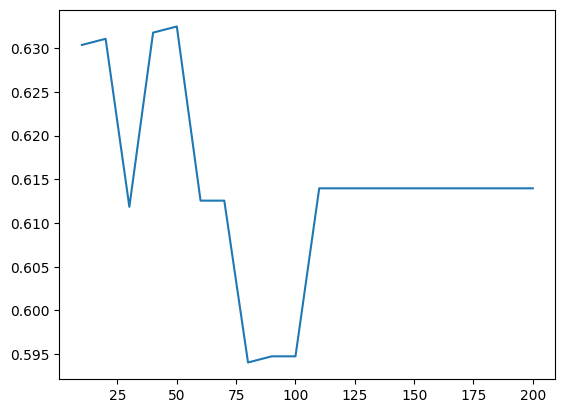

In [55]:
plt.plot(df_scores.n_estimators, df_scores.auc)

### Tuning **max_depth**

In [77]:
scores = []
for d in [10, 15, 20]:
    for n in range(10, 71, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=39,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [78]:
df_scores = pd.DataFrame(scores, columns=["max_depth", "n_estimators", "auc"])
df_scores.head()

,max_depth,n_estimators,auc
0,10,10,0.630384
1,10,20,0.612564
2,10,30,0.631795
3,10,40,0.631795
4,10,50,0.632500


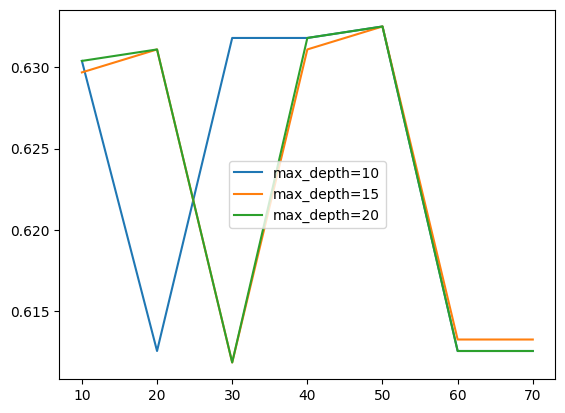

In [79]:
for d in [10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' % d)

plt.legend()

In [73]:
max_depth = 20

### Tuning **min_samples_leaf**

In [90]:
scores = []
for s in [1, 3, 5, 10]:
    for n in range(10, 71, 5):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=39,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [91]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

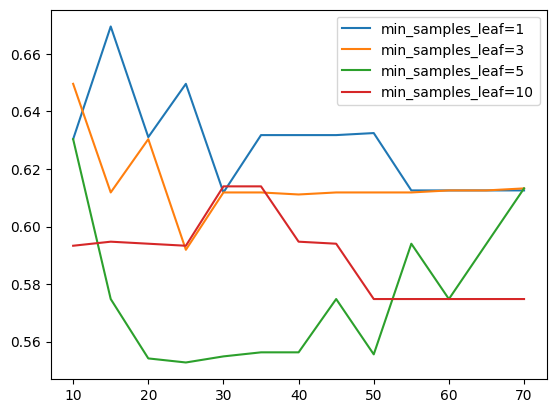

In [92]:
for s in [1, 3, 5, 10]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             #color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [93]:
min_samples_leaf = 1

### Best Random Forest model

In [94]:
rf = RandomForestClassifier(n_estimators=50,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=39,
                            n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
auc = roc_auc_score(y_val, y_pred)
print("AUC:", auc)

AUC: 0.6324997287620701
